####  Startup

Імпортування бібліотек та налаштування підключення до датабази

In [53]:
import pandas as pd
import datetime
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()
from sqlalchemy import create_engine
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import pmdarima as pm
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

main_color = 'blue'
light_color = '#d4d4ff'
default_figsize = (16, 6)
big_figsize = (16, 10)

# db connection
conn_str = ''
conn = create_engine(conn_str)

#### Формування датафрейму

Отримати вибірку із датабази. 
Відформатувати: 

1 - Перетворення років із чисельного формату у формат DateTime

2 - Встановлення часового стовбця як індексу датафрейму

3 - Перетворення грошових зборів із цілого числа до млн. долларів

4 - Заповнення пропусків (рокам, по яким немає грошових даних, встановити збори у 0 млн. долларів)

In [54]:
genre_name = 'Drama'
unf_df = pd.read_sql(f'SELECT      time_dim.year,     facts.gross FROM facts JOIN time_dim ON facts.time_dim = time_dim.id JOIN genre_group_dim ON facts.genre_group_id = genre_group_dim.id JOIN genre_combo ON genre_combo.genre_group_id = genre_group_dim.id JOIN genre_dim ON genre_dim.id = genre_combo.genre_id WHERE genre_dim.name = \'{genre_name}\' GROUP BY time_dim.year;', conn)

df = unf_df.drop(unf_df[unf_df['year'] < 1960].index)
df = df.drop(unf_df[unf_df['year'] > 2015].index)

df_trimmed = unf_df.drop(unf_df[unf_df['year'] < 2015].index)

# convert years to datetime
df['year'] = pd.to_datetime(df['year'], format='%Y')
df_trimmed['year'] = pd.to_datetime(df_trimmed['year'], format='%Y')

# set year as index
df.set_index(df['year'], inplace=True)
df_trimmed.set_index(df_trimmed['year'], inplace=True)

# fill missing years & set their gross values to 0
df = df.resample('A').sum().fillna(0)
df_trimmed = df_trimmed.resample('A').sum().fillna(0)

# set gross to be in millions
df['gross'] = df['gross'].div(1000000)
df_trimmed['gross'] = df_trimmed['gross'].div(1000000)


Намалювати графік на основі даних

<AxesSubplot:xlabel='Year', ylabel='Gross (millions USD)'>

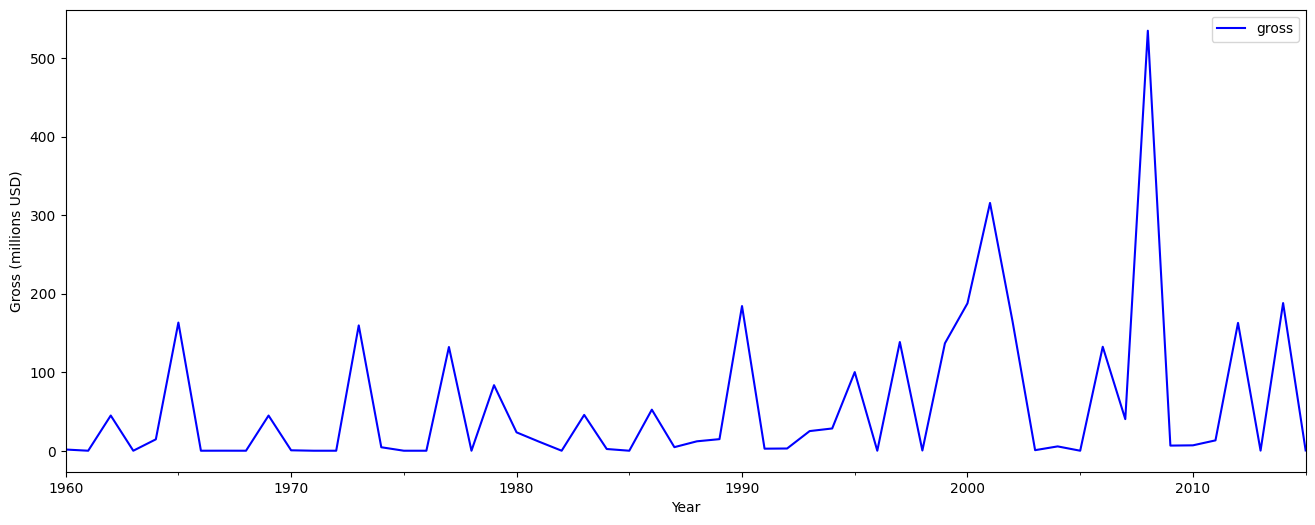

In [56]:
# plot
plt.style.use('default')
df.plot(xlabel='Year', ylabel='Gross (millions USD)',
    figsize=default_figsize, 
    color=main_color, 
    label='Drama')

#### Рухоме середнє

In [57]:
# moving average
def ma_plot(series, window, with_intervals=False):

    # set bg color to white
    plt.style.use('default')    

    plt.figure(figsize=default_figsize)
    plt.plot(series[window:], 
        color=light_color, 
        label='Actual values')
    plt.legend(loc='best')

    # moving average
    rolling_mean = series.rolling(window=window).mean()

    plt.title(f'Moving average\nWindows size - {window} year(-s)')
    plt.plot(rolling_mean, 
        color=main_color, 
        label='Rolling mean trend')
    plt.legend(loc='best')

    # moving average confidence interval
    if with_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bound = rolling_mean - (mae + 1.96 * deviation)
        upper_bound = rolling_mean + (mae + 1.96 * deviation)
        plt.plot(upper_bound, 
            'g--', 
            label='Upper bound / Lower bound')
        plt.plot(lower_bound, 
            'g--')
        plt.legend(loc='best')


Намалювати графіки рухомого середнього із "вікнами" у розмірі 2 та 5 років

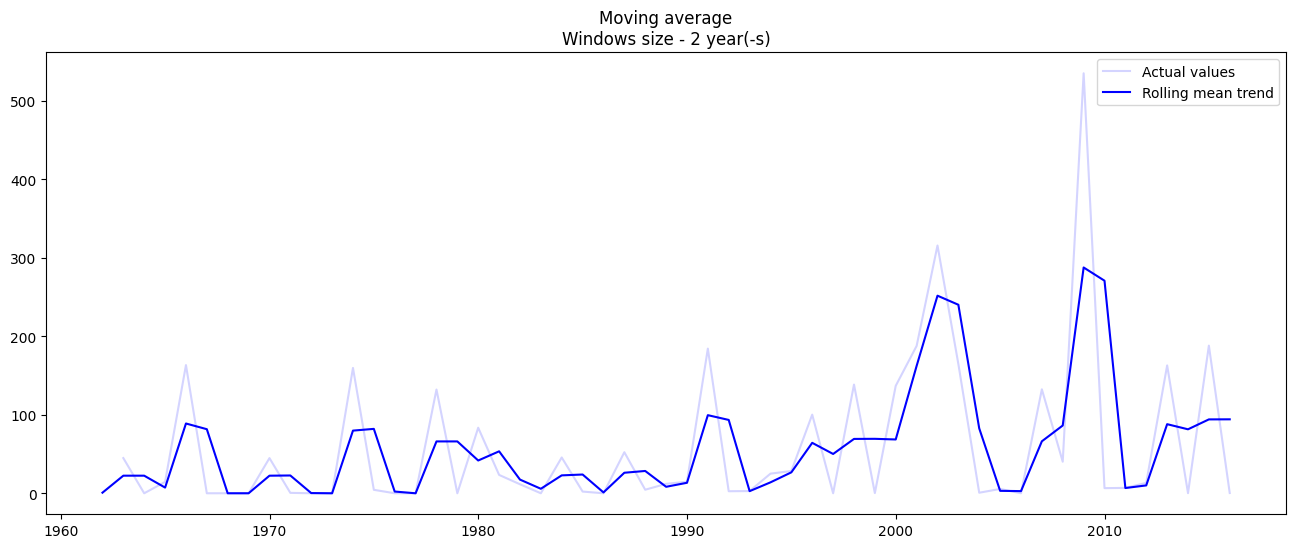

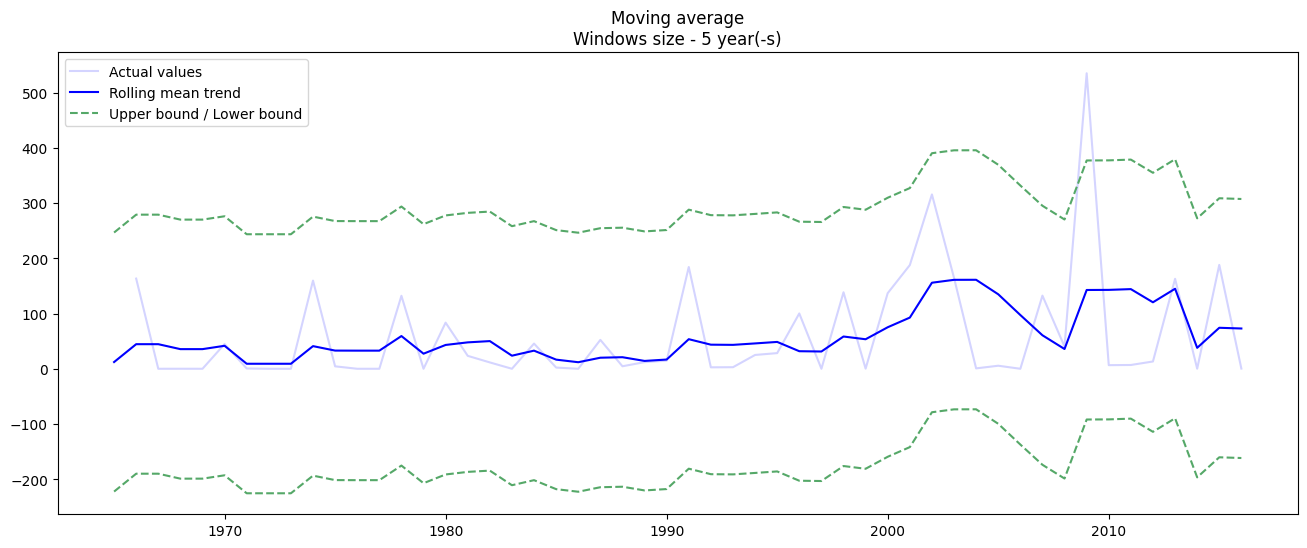

In [58]:
# plot moving average
ma_plot(df['gross'], 2)

ma_plot(df['gross'], 5, True)

#### Експоненціальне згладжування

Звичайне

In [59]:
def exp_smoothing(series, alpha):

    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result
  

def plot_exp_smoothing(series, alpha):
 
    plt.style.use('default')

    plt.figure(figsize=default_figsize)
    plt.plot(series.values, color=light_color, label="Actual")
    plt.legend(loc="best")

    plt.title(f"Exponential Smoothing\nAlpha - {alpha}")
    plt.plot(exp_smoothing(series, alpha), color=main_color, label="Smoothed")
    plt.legend(loc="best")

Подвійне

In [60]:
def double_exp_smoothing(series, alpha, beta):

    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series):
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha * value + (1 - alpha) * (level + trend)
        trend = beta * (level - last_level) + (1 - beta) * trend
        result.append(level + trend)
    return result

def plot_double_exp_smoothing(series, alpha, beta):

    plt.style.use('default')

    plt.figure(figsize=default_figsize)
    plt.plot(series.values, color=light_color, label="Actual")
    plt.legend(loc="best")
    
    plt.title(f"Double Exponential Smoothing\nAlpha: {alpha}, Beta: {beta}")
    plt.plot(double_exp_smoothing(series, alpha, beta), color=main_color, label="Smoothed")
    plt.legend(loc="best")

Намалювати графіки експоненціального згладжування

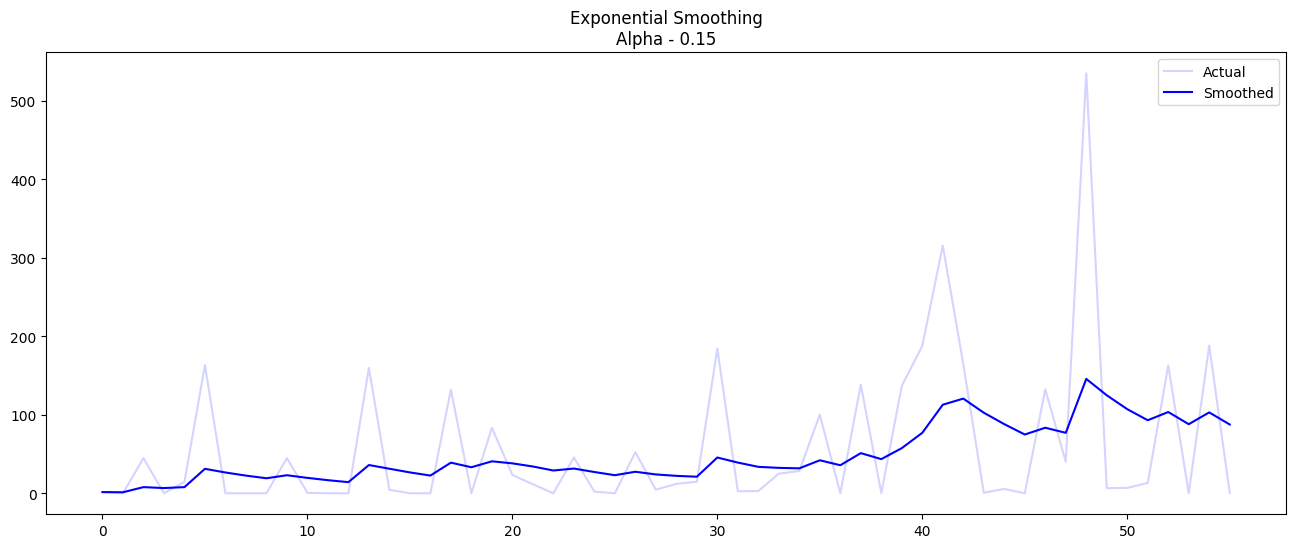

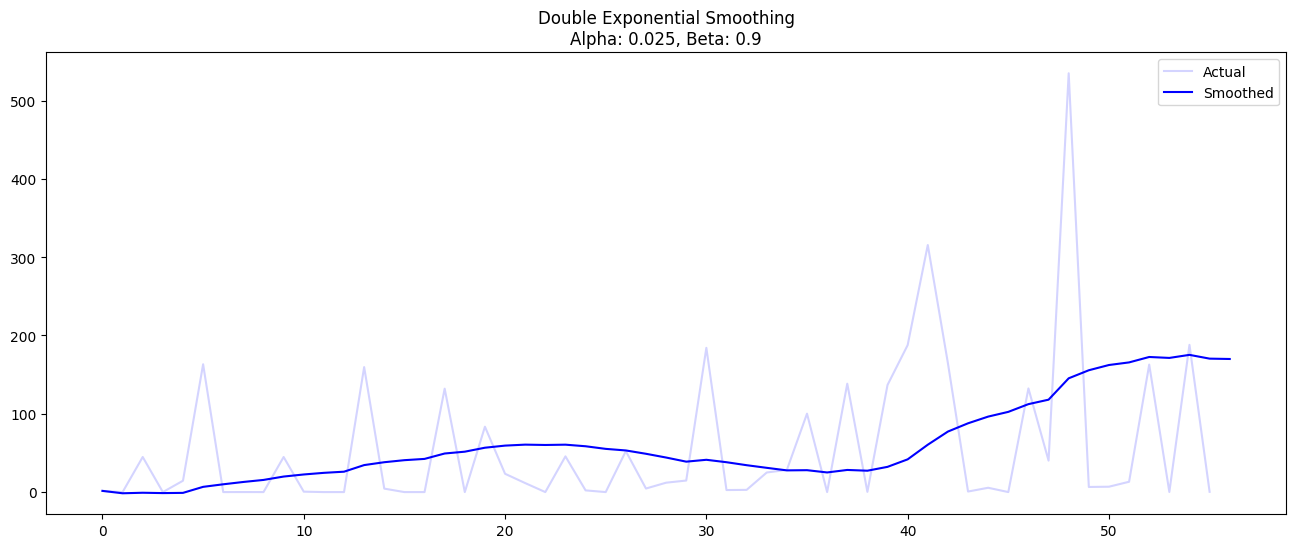

In [61]:
plot_exp_smoothing(df['gross'], alpha=0.15)
plot_double_exp_smoothing(df['gross'], alpha=0.025, beta=0.9)

#### Моделювання

##### Перевірка на сезонність

<AxesSubplot:xlabel='year'>

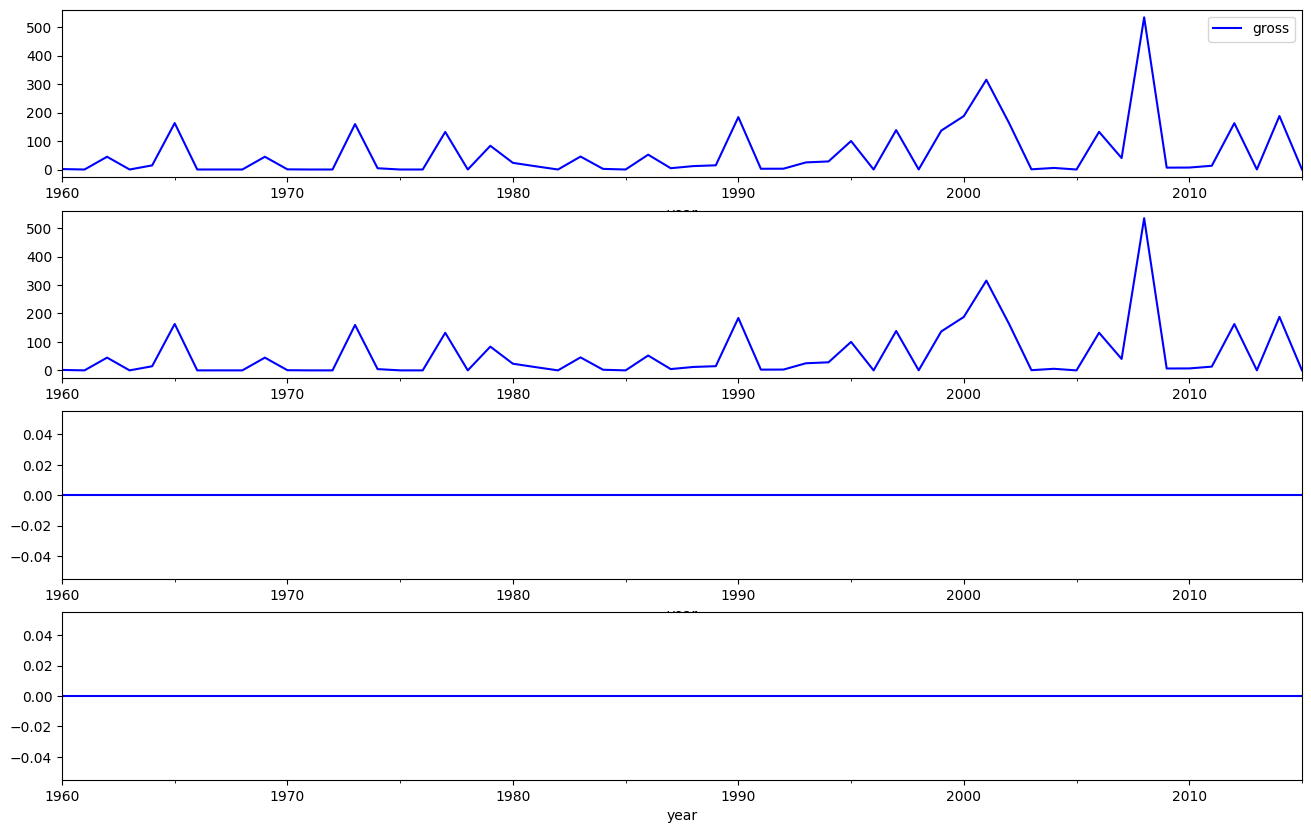

In [62]:
deomposed = seasonal_decompose(df['gross'], model='additive')

fig, axes = plt.subplots(nrows=4, figsize=big_figsize)
plt.style.use('default')

trend = deomposed.trend
seasonal = deomposed.seasonal
residual = deomposed.resid

df.plot(ax=axes[0], color=main_color, label='Actual')
trend.plot(ax=axes[1], color=main_color, label='Trend')
seasonal.plot(ax=axes[2], color=main_color, label='Seasonal')
residual.plot(ax=axes[3], color=main_color, label='Residual')

##### Провести тест Дікі-Фуллера для перевірки на стаціонарність

In [73]:
dft_df = df.copy()

result = adfuller(dft_df['gross'], autolag='AIC')

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')

for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
if result[0] < result[4]["5%"]:
    print("Stationary")
else:
    print("Non-Stationary")


ADF Statistic: -7.319137
p-value: 0.000244
Critical Values:
	1%: -3.555
	5%: -2.916
	10%: -2.596
Stationary


##### Автокорреляція та часткова автокорреляція

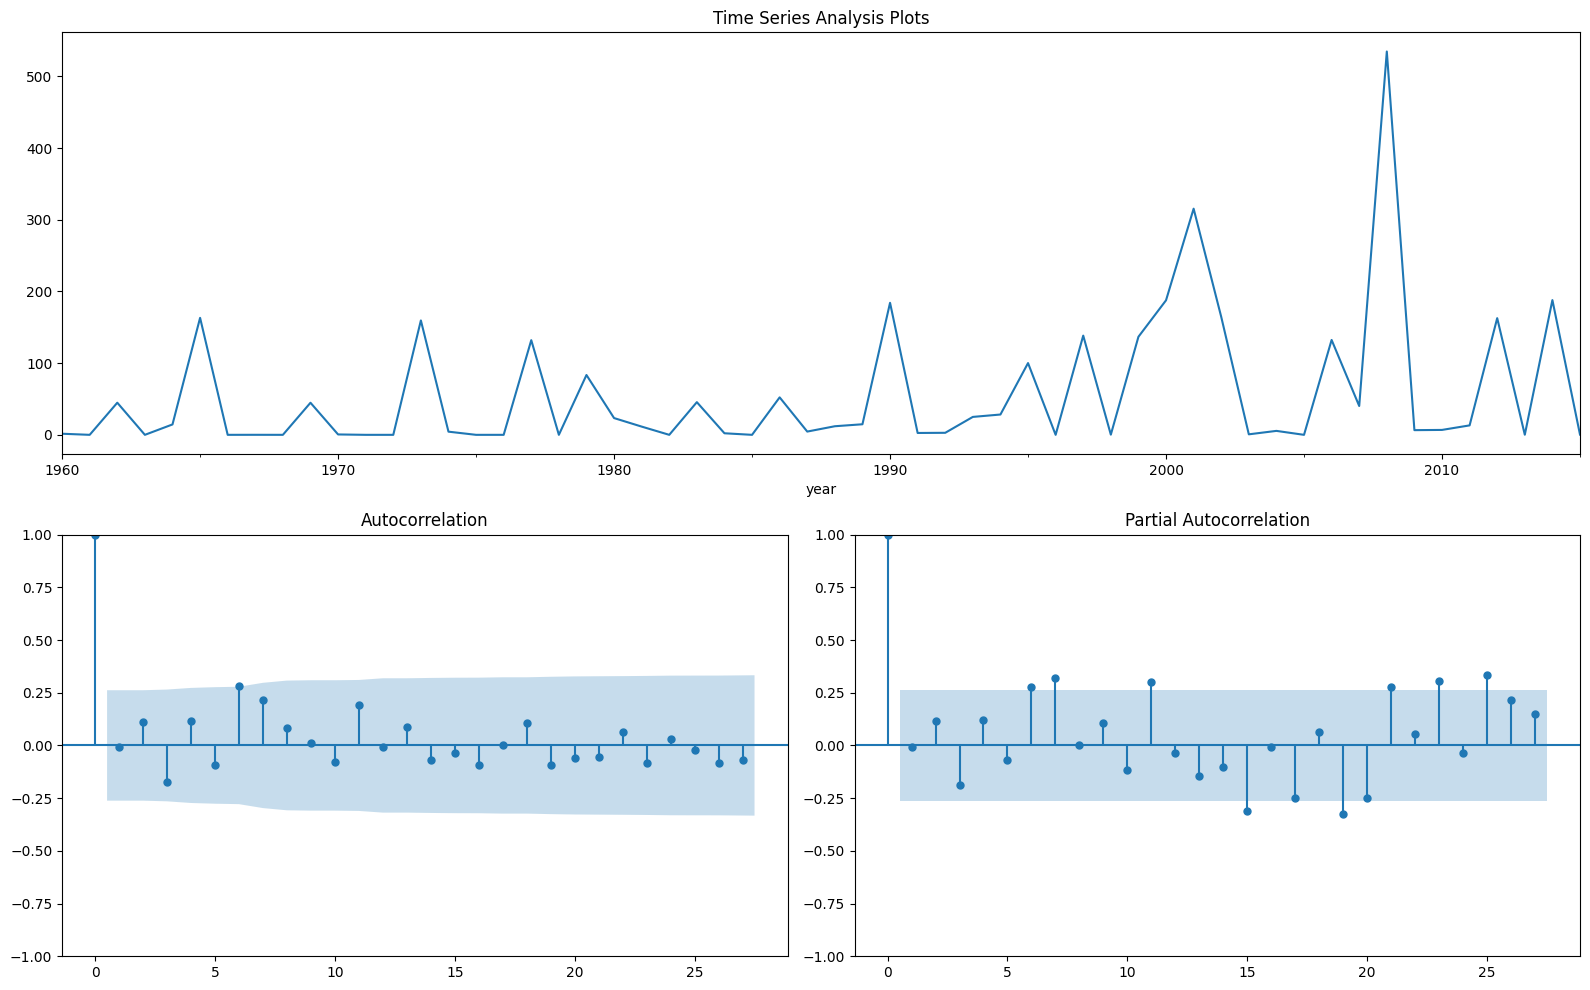

In [64]:
def tsaplot(y, lags=None):

    if not isinstance(y, pd.Series):
        y = pd.Series(y)

    with plt.style.context(style='bmh'):
        plt.style.use('default')
        plt.figure(figsize=big_figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()


tsaplot(df['gross'], lags=27)

##### Метод для побудови передбачення

In [65]:
def fc_plot(model, periods, title='Forecast', trimmed=None, is_sarimax=False):

    periods = periods+1

    if is_sarimax:
        mse = sarimax_forecast(model, periods, title, trimmed)
        return mse

    # Forecast
    n_periods = periods
    fitted, confint = model.predict(n_periods=n_periods, return_conf_int=True)
    index_of_fc = pd.date_range(df.index[-1], periods=n_periods, freq='A')

    # make series for plotting purpose
    fitted_series = pd.Series(fitted, index=index_of_fc)

    plt.figure(figsize=default_figsize)
    plt.plot(df["gross"], color=main_color, label="Actual")
    if trimmed is not None:
        plt.plot(df_trimmed, color='yellow', label="Expected")
    plt.plot(fitted_series, color='orange', label="Forecast")
    plt.title(title)
    plt.legend(loc="best")
    plt.show()

    if trimmed is not None:
        mse = mean_squared_error(df_trimmed.tail(periods).values, 
            fitted_series.tail(periods).values)
        return mse


def sarimax_forecast(model, periods, title='Forecast', trimmed=None):
    # Forecast
    n_periods = periods

    forecast_df = pd.DataFrame({"year_index":pd.date_range(df.index[-1], periods = n_periods, freq='A').year},
        index = pd.date_range(df.index[-1], periods = n_periods, freq='A'))

    fitted, confint = model.predict(n_periods=n_periods,
        return_conf_int=True,
        exogenous=forecast_df[['year_index']])
        
    index_of_fc = pd.date_range(df.index[-1], periods = n_periods, freq='A')

    # make series for plotting purpose
    fitted_series = pd.Series(fitted, index=index_of_fc)

    # Plot
    plt.figure(figsize=(15,7))
    plt.plot(df['gross'], color=main_color, label="Actual")
    if trimmed is not None:
        plt.plot(df_trimmed, color='yellow', label="Expected")
    plt.plot(fitted_series, color='orange', label="Forecast")
    plt.title(title)
    plt.show()

    if trimmed is not None:
        mse = mean_squared_error(df_trimmed.tail(periods).values, 
            fitted_series.tail(periods).values)
        return mse

##### Arima

Тренування моделі

In [66]:
arima_model = pm.auto_arima(df['gross'], 
    start_p=1, max_p=5,
    start_q=1, max_q=5,
    test='adf', d=None,     # adftest for 'd'
    m=1, seasonal=False,    # no seasonality for standard ARIMA
    trace=False,            # logs 
    error_action='warn', suppress_warnings=True,
    stepwise=True)

print(arima_model.summary())


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   56
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -336.066
Date:                Fri, 17 Jun 2022   AIC                            678.132
Time:                        13:21:30   BIC                            684.208
Sample:                             0   HQIC                           680.488
                                 - 56                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9915      0.053     18.714      0.000       0.888       1.095
ma.L1         -0.9143      0.133     -6.886      0.000      -1.174      -0.654
sigma2      9359.1985   1223.411      7.650      0.0

Діагностика

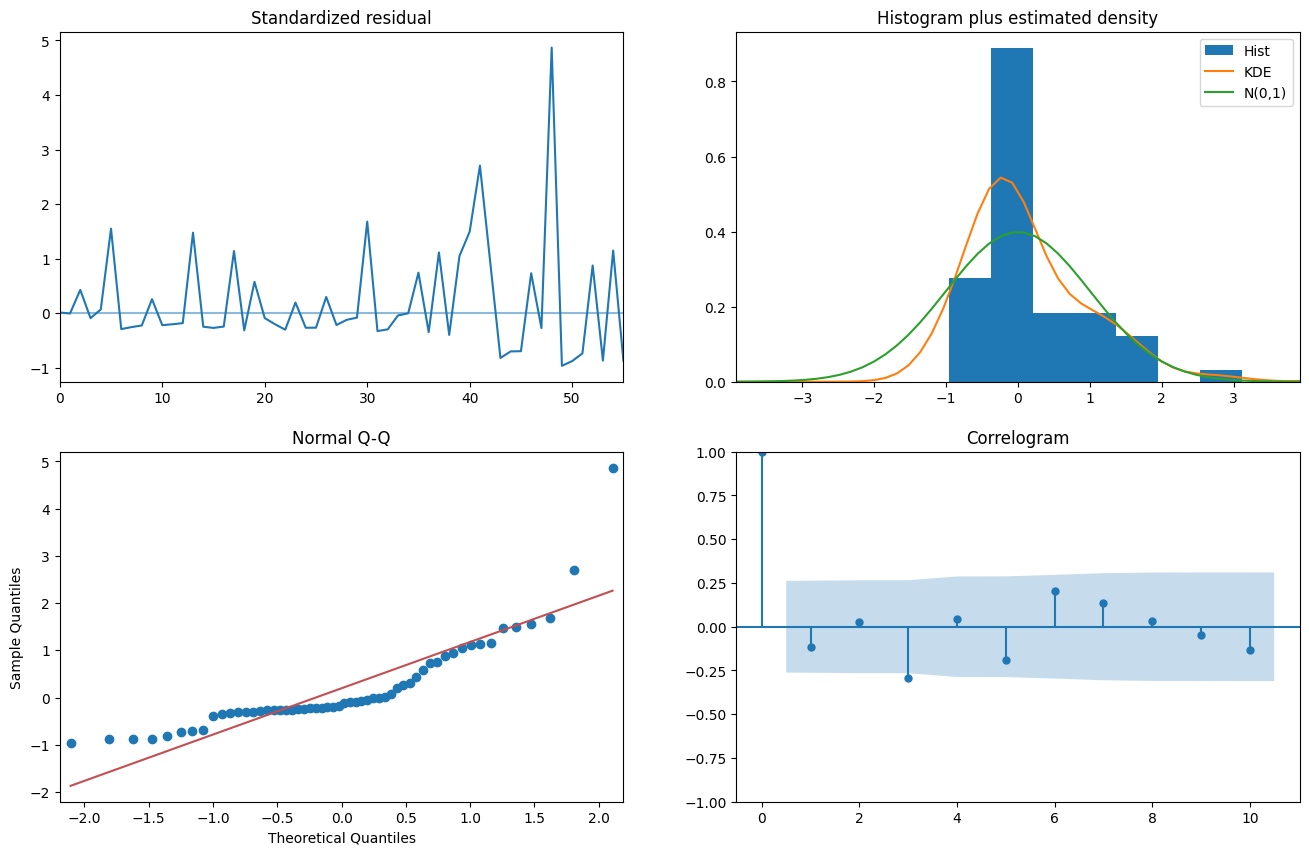

In [67]:
arima_model.plot_diagnostics(figsize=big_figsize)
plt.show()

Передбачення

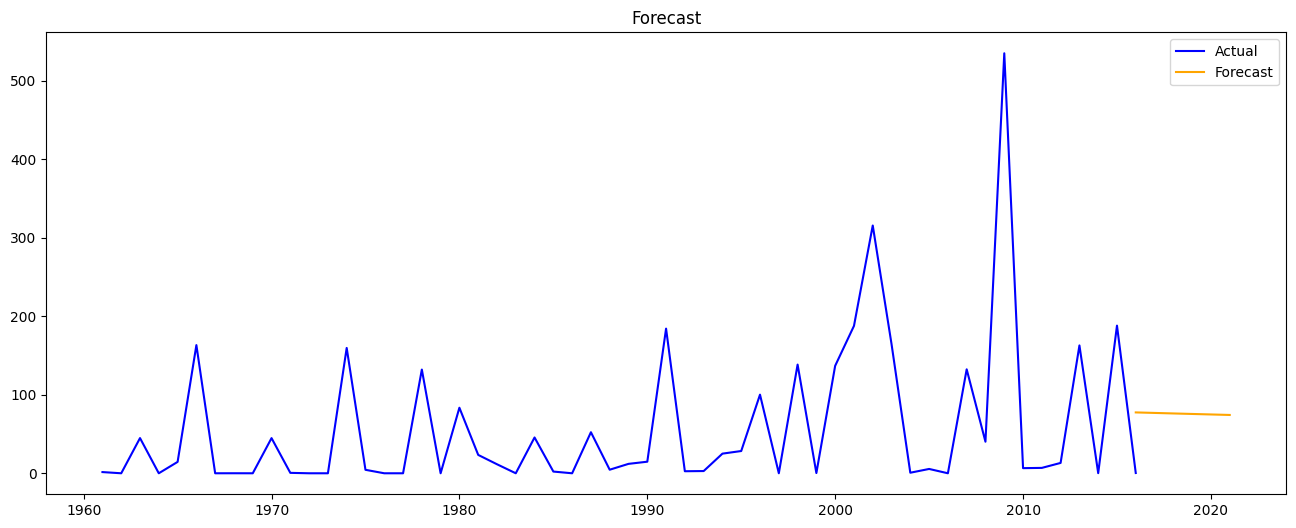

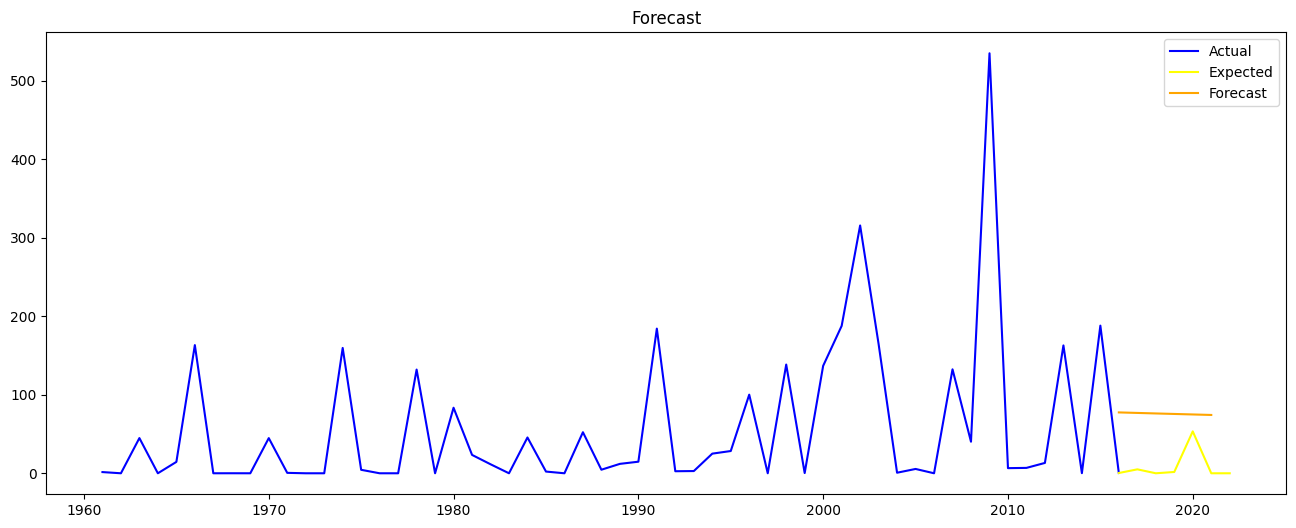

In [68]:
fc_plot(arima_model, 5)
arima_model.mse = fc_plot(arima_model, 5, trimmed=df_trimmed['gross'])

##### Sarima

Тренування моделі

In [69]:
sarima_model = pm.auto_arima(df['gross'], 
    start_p=1, max_p=5,
    start_q=1, max_q=5, 
    test='adf',
    m=5, seasonal=True, #set to seasonal
    start_P=0,
    d=None, D=1,
    trace=False,
    error_action='ignore', suppress_warnings=True, 
    stepwise=True)

print(sarima_model.summary())


                                 SARIMAX Results                                 
Dep. Variable:                         y   No. Observations:                   56
Model:              SARIMA(0, 1, [1], 5)   Log Likelihood                -313.361
Date:                   Fri, 17 Jun 2022   AIC                            630.722
Time:                           13:50:16   BIC                            634.585
Sample:                                0   HQIC                           632.198
                                    - 56                                         
Covariance Type:                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L5       -0.8880      0.293     -3.031      0.002      -1.462      -0.314
sigma2      1.101e+04   1985.978      5.546      0.000    7122.511    1.49e+04
Ljung-Box (L1) (Q):         

Діагностика

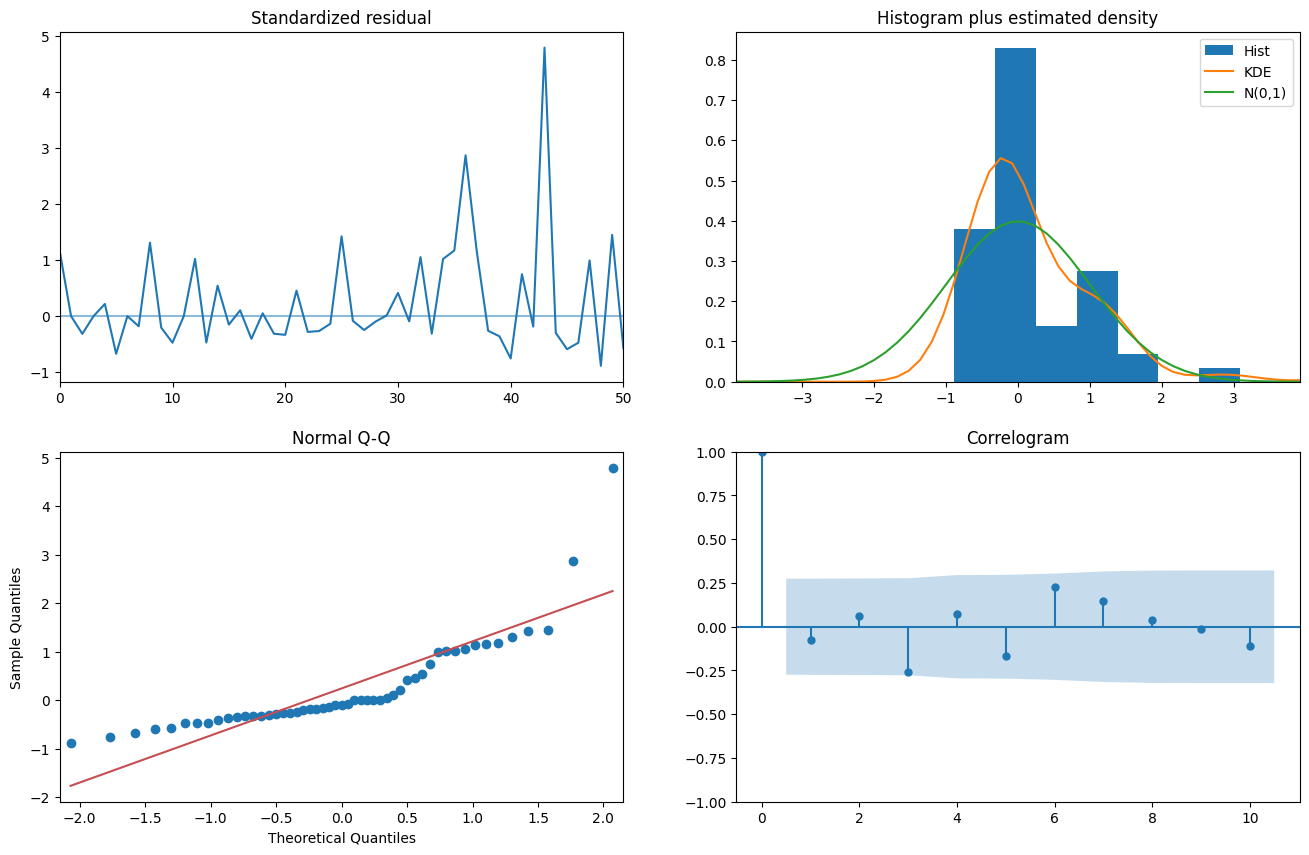

In [70]:
sarima_model.plot_diagnostics(figsize=big_figsize)
plt.show()

Передбачення

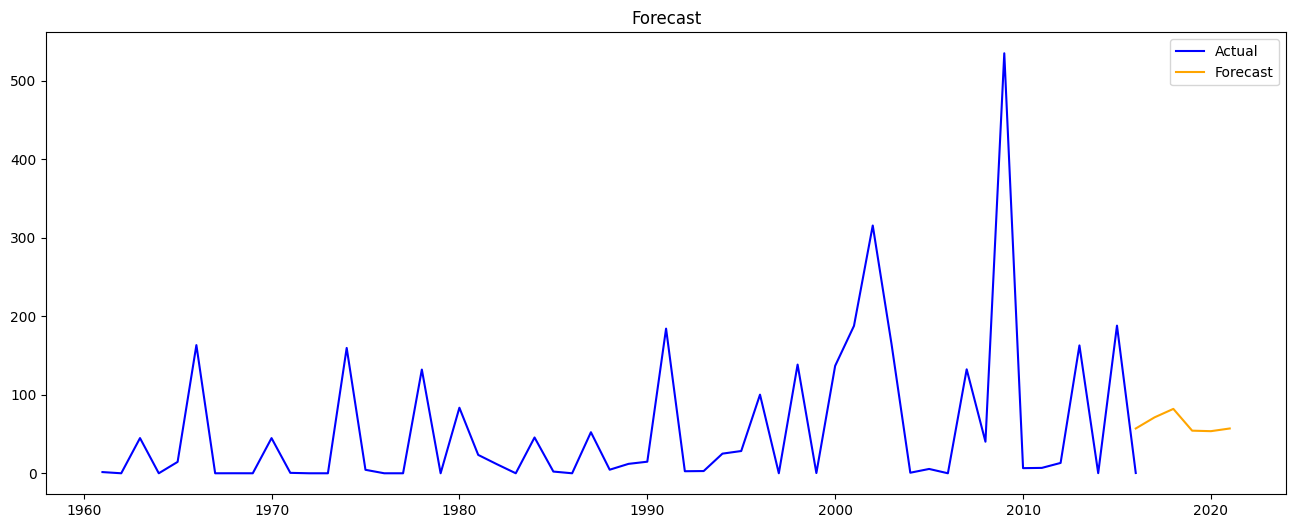

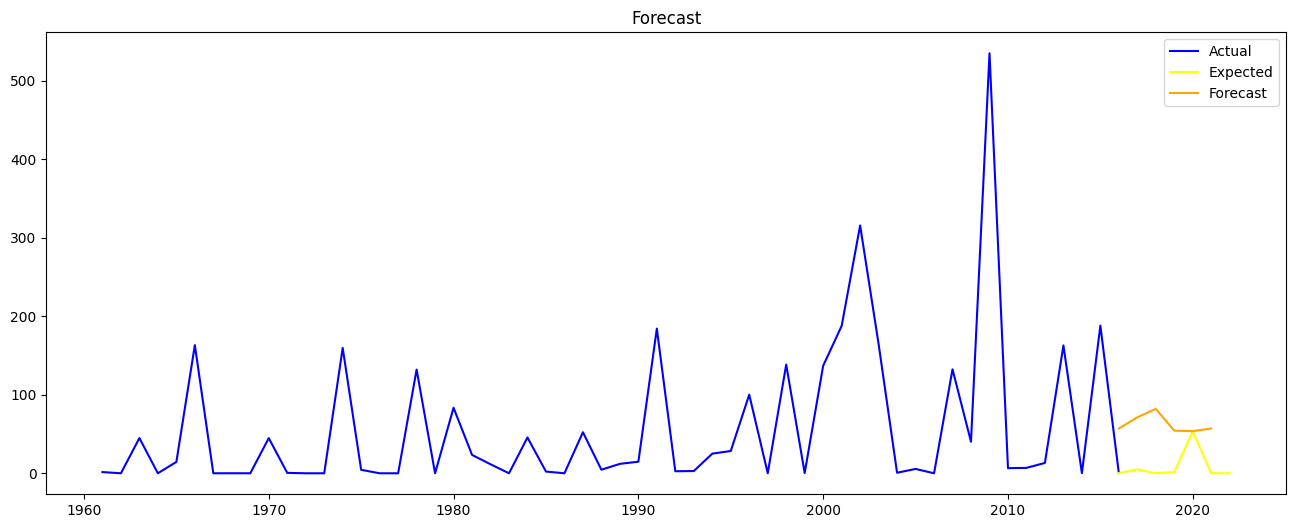

In [71]:
fc_plot(sarima_model, 5)
sarima_model.mse = fc_plot(sarima_model, 5, trimmed=df_trimmed['gross'])


##### Порівняння MSE

In [72]:
mse_list = {
    'ARIMA': arima_model.mse,
    'SARIMA': sarima_model.mse
}

for w in sorted(mse_list, key=mse_list.get):
    print(w, mse_list[w])

SARIMA 3394.1802034687976
ARIMA 4722.291184629598
